In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn.functional import cosine_similarity
from torchvision import datasets
from torchvision.transforms import v2 as T
import random
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights, mnasnet1_3, MNASNet1_3_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm

Цель исследования найти предобученные сверточные модели, которые можно использовать для получения эмбеддингов изображений. Важным требованием является то, чтобы модели были достаточно легкими и быстрыми для того, чтобы пропустить ~100 изображений, используя CPU, когда нет возможности использовать GPU. Тем не менее метрика сходства тоже важна и остается прежней:

$ y = \sum_{i=1} ^{N} cossim(A1_i, A2_i) - cossim(A_i, B_i) $

где:
- $A1, A2$ - множество объектов одного класса. $ A1 \neq A2 $ 
- $B$ - множество объектов отличных от класса объектов в множестве $A1$

### Загрузим датасет

In [2]:
torch.manual_seed(0)

caltech101 = datasets.Caltech101(
    root='test_data/caltech101/',
    target_type='category',
    transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: T.Grayscale(3)(x) if x.shape[0] == 1 else x),
    ]),
    download=True
)

valid_images = []
airplanes = []
already_taken = []
for image in caltech101:
    if len(already_taken) == 100:
        break
    if image[1] == 5:
        airplanes.append(image[0])
    elif image[1] not in already_taken:
        valid_images.append(image[0])
        already_taken.append(image[1])

valid_airplanes = random.sample(airplanes, 100)

Files already downloaded and verified


### Подготовим вспомогательные функции

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [4]:
def get_cosine_similarity(model, first_data, secod_data):
    if hasattr(model, 'encode'):
        first = model.encode(torch.stack(first_data).to(DEVICE)).cpu()
        second = model.encode(torch.stack(secod_data).to(DEVICE)).cpu()
    else:
        first = model(torch.stack(first_data).to(DEVICE)).cpu()
        second = model(torch.stack(secod_data).to(DEVICE)).cpu()
        
    result = cosine_similarity(first, second)
    return [x.item() for x in result]

def shift_objects_in_list(data, shift):
    data_ = data[shift:]
    data_.extend(data[:shift])
    return data_

In [5]:
def plot_similarity(a, b, title):
    plt.figure(figsize=(12, 4))
    sns.histplot((a, b), kde=True,  bins=50, alpha=0.5)
    plt.xlim(0, 1)
    plt.legend(
        [f'mean cossim(A1, A2): {round(np.mean(a) * 100, 2)}%',
         f'mean cossim(A1, B): {round(np.mean(b) * 100, 2)}%',
         'cossim(A1, B)',
         'cossim(A1, A2)',
         ],
        title=f'diff between mean samples: {round((np.mean(a) - np.mean(b))* 100, 2)} pp'
    )
    plt.axvline(x=np.mean(a), alpha=1, color='blue')
    plt.axvline(x=np.mean(b), alpha=1, color='red')
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('red')
    if title:
        plt.title(title)
    plt.show()

### Сравниваем модели

В качестве легких и быстрых моделей будем использовать [MobileNet_v3_large](https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large) и [MNASNet_v1_3](https://pytorch.org/vision/stable/models/generated/torchvision.models.mnasnet1_3.html#torchvision.models.mnasnet1_3)

In [6]:
mobilenet_model = mobilenet_v3_large(MobileNet_V3_Large_Weights)
mobilenet_model.classifier = nn.Sequential(*list(mobilenet_model.classifier.children())[:-3])

In [7]:
transform_192=T.Resize((192, 192))

100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


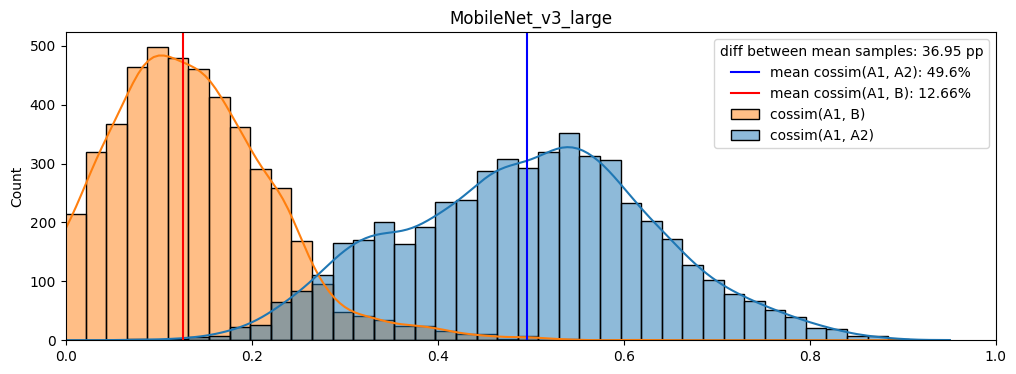

In [8]:
mobilenet_model.eval()
mobilenet_model.to(DEVICE)

a_a_sim, a_b_sim = [], []
airplanes_ = [transform_192(x) for x in valid_airplanes]
images_ = [transform_192(x) for x in valid_images]
for i in tqdm(range(1, 51)):
    a_a_sim.extend(get_cosine_similarity(mobilenet_model, airplanes_, shift_objects_in_list(airplanes_, i)))
    a_b_sim.extend(get_cosine_similarity(mobilenet_model, airplanes_, shift_objects_in_list(images_, i)))

plot_similarity(
    a_a_sim,
    a_b_sim,
    title='MobileNet_v3_large'
)

In [9]:
mnasnet1_3_model = mnasnet1_3(MNASNet1_3_Weights)
mnasnet1_3_model.classifier[1] = nn.Flatten()

100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


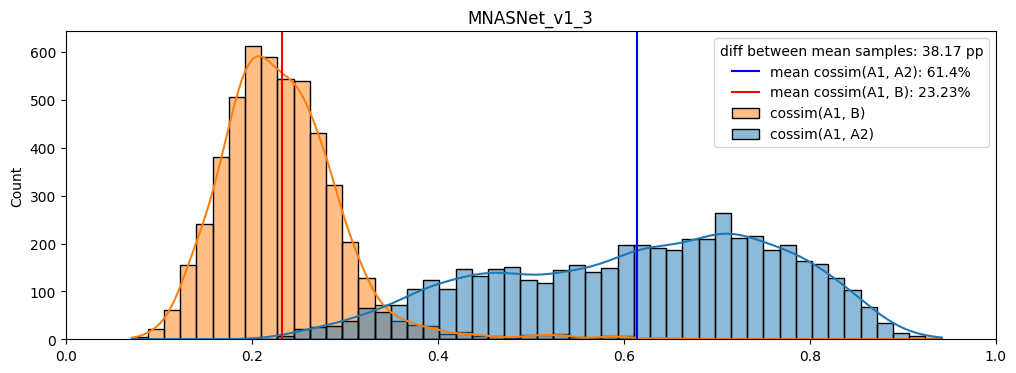

In [10]:
mnasnet1_3_model.eval()
mnasnet1_3_model.to(DEVICE)

a_a_sim, a_b_sim = [], []
airplanes_ = [transform_192(x) for x in valid_airplanes]
images_ = [transform_192(x) for x in valid_images]
for i in tqdm(range(1, 51)):
    a_a_sim.extend(get_cosine_similarity(mnasnet1_3_model, airplanes_, shift_objects_in_list(airplanes_, i)))
    a_b_sim.extend(get_cosine_similarity(mnasnet1_3_model, airplanes_, shift_objects_in_list(images_, i)))

plot_similarity(
    a_a_sim,
    a_b_sim,
    title='MNASNet_v1_3'
)

MNASNet_v1_3 оказалась сильнее, чем MobileNet_v3_large, однако она почти в 3 раза медленнее.

Посмотрим на результаты моделей при различных размерах исходных изображений.

100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


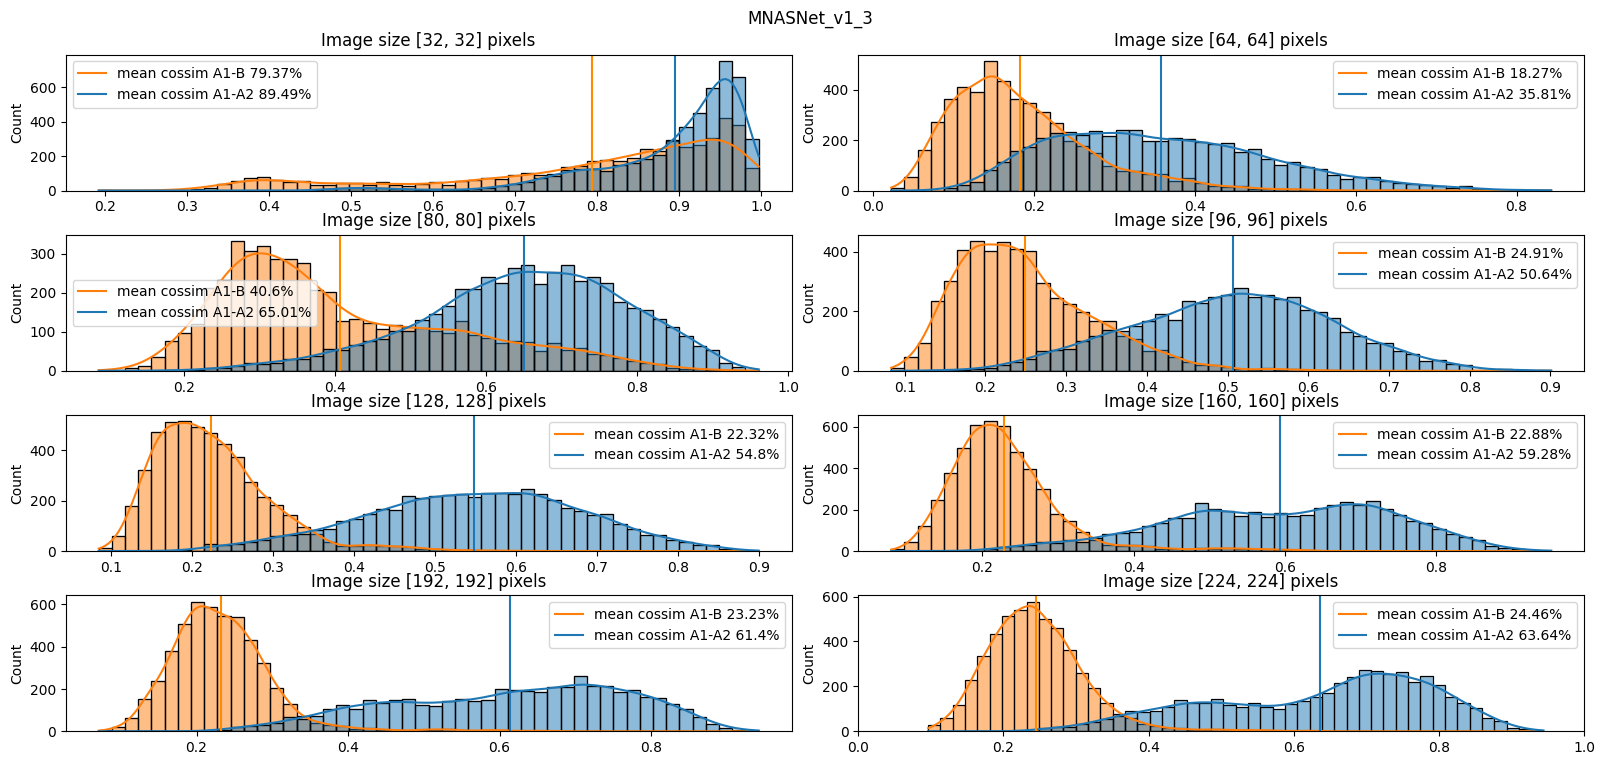

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(16, 8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax = axs.ravel()

for idx, transformer in enumerate([T.Resize((32, 32)), T.Resize((64, 64)), T.Resize((80, 80)), T.Resize((96, 96)), T.Resize((128, 128)), T.Resize((160, 160)), T.Resize((192, 192)), T.Resize((224, 224))]):

    airplanes_ = [transformer(x) for x in valid_airplanes]
    images_ = [transformer(x) for x in valid_images]
    
    mnasnet1_3_model.eval()
    mnasnet1_3_model.to(DEVICE)
    a_a_sim, a_b_sim = [], []

    for i in tqdm(range(1, 51)):
        a_a_sim.extend(get_cosine_similarity(mnasnet1_3_model, airplanes_, shift_objects_in_list(airplanes_, i)))
        a_b_sim.extend(get_cosine_similarity(mnasnet1_3_model, airplanes_, shift_objects_in_list(images_, i)))

    sns.histplot((a_a_sim, a_b_sim), kde=True,  bins=50, alpha=0.5, ax=ax[idx])
    plt.xlim(0, 1)
    ax[idx].axvline(x=np.mean(a_a_sim), alpha=1)
    ax[idx].axvline(x=np.mean(a_b_sim), alpha=1, color='darkorange')
    ax[idx].legend([f'mean cossim A1-B {round(np.mean(a_b_sim) * 100, 2)}%', f'mean cossim A1-A2 {round(np.mean(a_a_sim) * 100, 2)}%'])
    ax[idx].title.set_text(f'Image size {transformer.size} pixels')

    torch.cuda.empty_cache()

fig.suptitle('MNASNet_v1_3')
plt.show()

100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


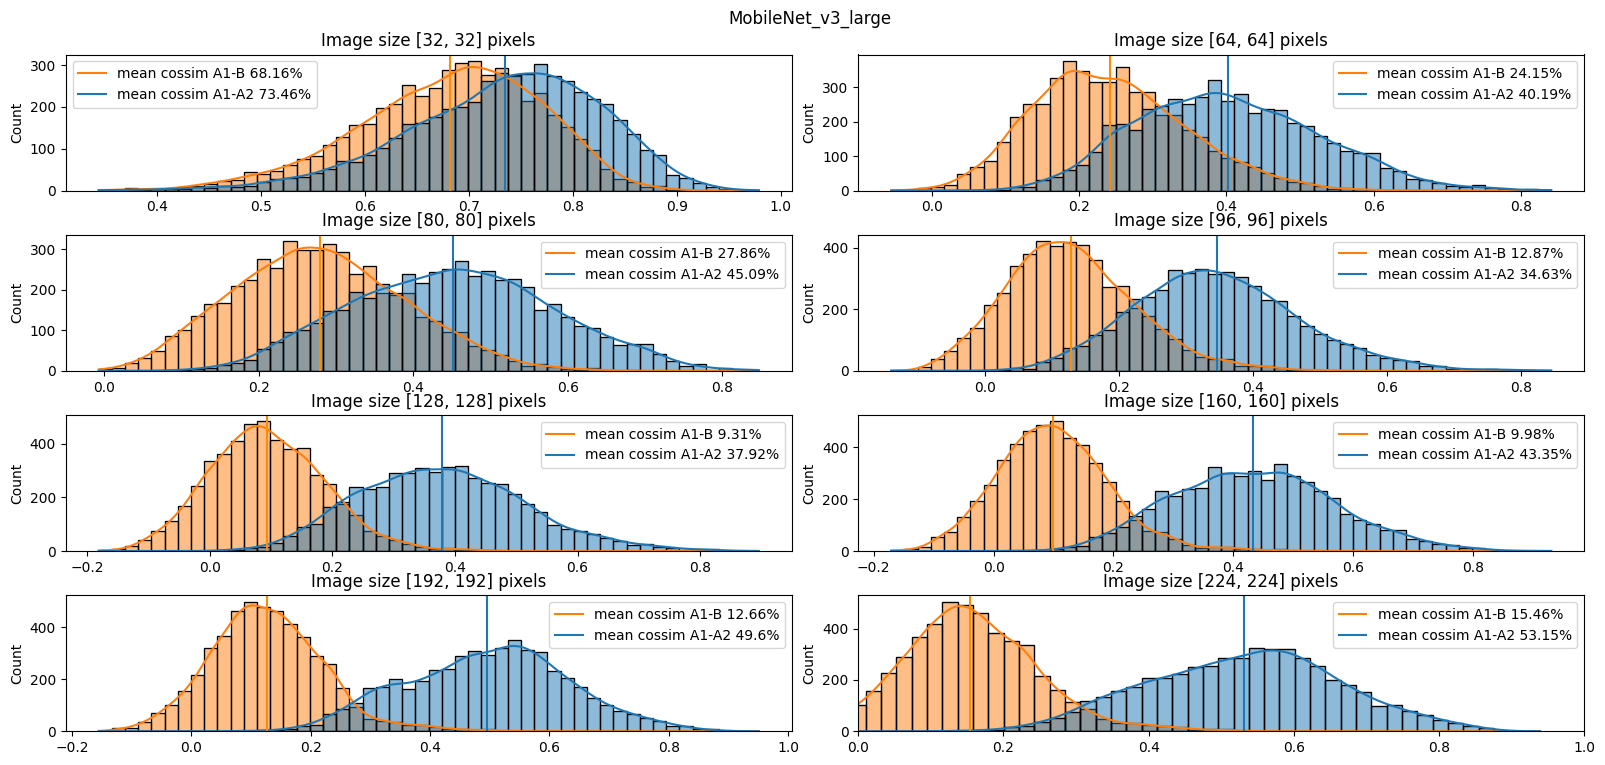

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(16, 8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax = axs.ravel()

for idx, transformer in enumerate([T.Resize((32, 32)), T.Resize((64, 64)), T.Resize((80, 80)), T.Resize((96, 96)), T.Resize((128, 128)), T.Resize((160, 160)), T.Resize((192, 192)), T.Resize((224, 224))]):
    
    airplanes_ = [transformer(x) for x in valid_airplanes]
    images_ = [transformer(x) for x in valid_images]
    
    mobilenet_model.eval()
    mobilenet_model.to(DEVICE)
    a_a_sim, a_b_sim = [], []

    for i in tqdm(range(1, 51)):
        a_a_sim.extend(get_cosine_similarity(mobilenet_model, airplanes_, shift_objects_in_list(airplanes_, i)))
        a_b_sim.extend(get_cosine_similarity(mobilenet_model, airplanes_, shift_objects_in_list(images_, i)))


    sns.histplot((a_a_sim, a_b_sim), kde=True,  bins=50, alpha=0.5, ax=ax[idx])
    plt.xlim(0, 1)
    ax[idx].axvline(x=np.mean(a_a_sim), alpha=1)
    ax[idx].axvline(x=np.mean(a_b_sim), alpha=1, color='darkorange')
    ax[idx].legend([f'mean cossim A1-B {round(np.mean(a_b_sim) * 100, 2)}%', f'mean cossim A1-A2 {round(np.mean(a_a_sim) * 100, 2)}%'])
    ax[idx].title.set_text(f'Image size {transformer.size} pixels')

    torch.cuda.empty_cache()

fig.suptitle('MobileNet_v3_large')
plt.show()

У обеих моделей видна тенденция на увеличение разницы между A1-B и A1-A2 при увеличении размера исходного изображения. MNASNet_v1_3 все еще сильнее, чем MobileNet_v3_large. За основную модель сервиса можно взять MNASNet_v1_3, а MobileNet_v3_large использовать в случаях, когда будет важна скорость ответа сервиса.

Дополнительно посмотрим на MobileNet_v3_small, которая является более легкой версией MobileNet_v3_large.

100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


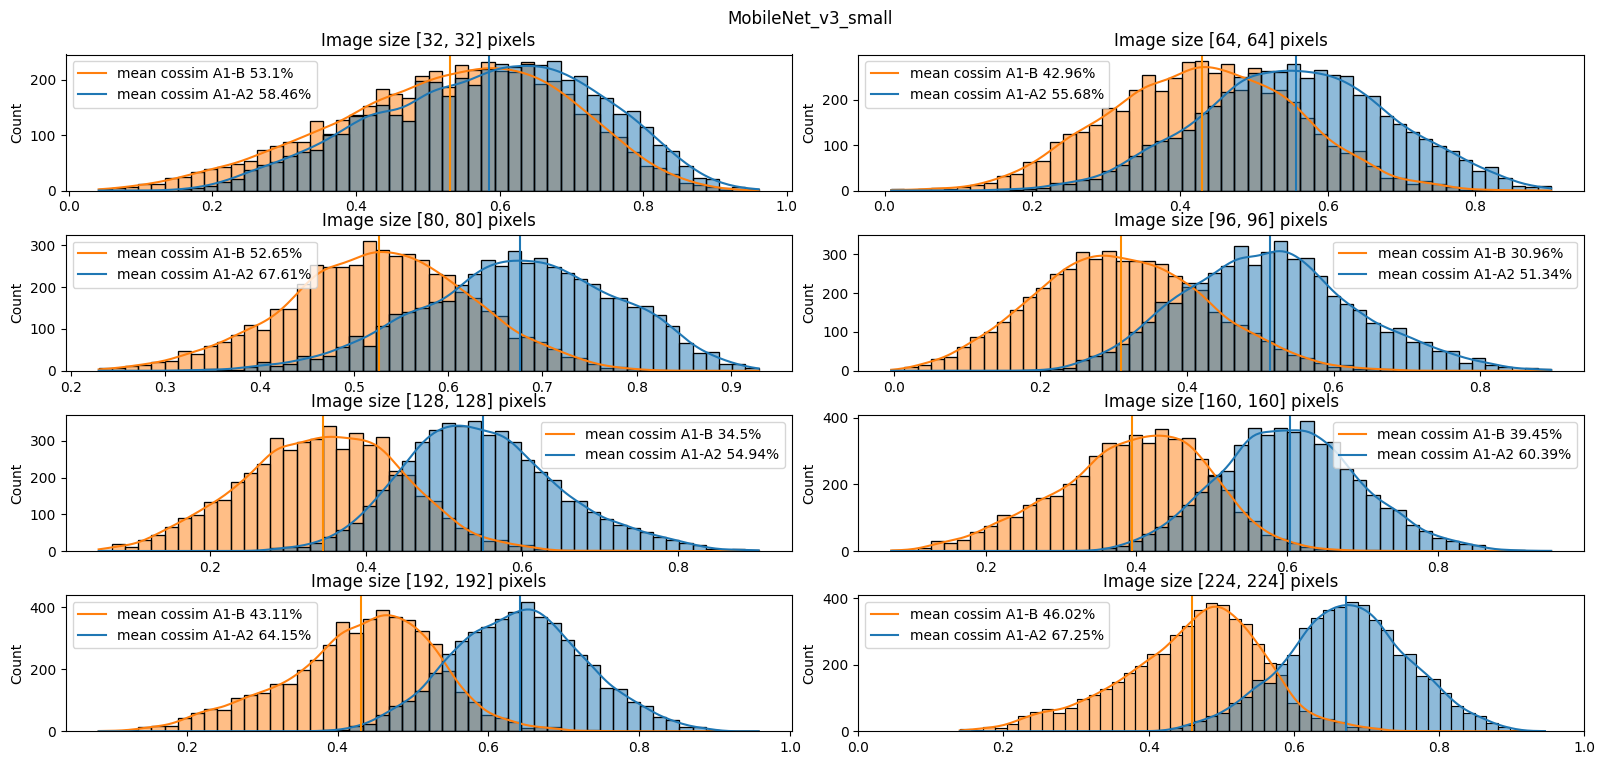

In [13]:
mobilenet_small_model = mobilenet_v3_small(MobileNet_V3_Small_Weights)
mobilenet_small_model.classifier = nn.Sequential(*list(mobilenet_model.classifier.children())[:-3])

fig, axs = plt.subplots(4, 2, figsize=(16, 8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax = axs.ravel()

for idx, transformer in enumerate([T.Resize((32, 32)), T.Resize((64, 64)), T.Resize((80, 80)), T.Resize((96, 96)), T.Resize((128, 128)), T.Resize((160, 160)), T.Resize((192, 192)), T.Resize((224, 224))]):
    
    airplanes_ = [transformer(x) for x in valid_airplanes]
    images_ = [transformer(x) for x in valid_images]
    
    mobilenet_small_model.eval()
    mobilenet_small_model.to(DEVICE)
    a_a_sim, a_b_sim = [], []

    for i in tqdm(range(1, 51)):
        a_a_sim.extend(get_cosine_similarity(mobilenet_small_model, airplanes_, shift_objects_in_list(airplanes_, i)))
        a_b_sim.extend(get_cosine_similarity(mobilenet_small_model, airplanes_, shift_objects_in_list(images_, i)))

    sns.histplot((a_a_sim, a_b_sim), kde=True,  bins=50, alpha=0.5, ax=ax[idx])
    plt.xlim(0, 1)
    ax[idx].axvline(x=np.mean(a_a_sim), alpha=1)
    ax[idx].axvline(x=np.mean(a_b_sim), alpha=1, color='darkorange')
    ax[idx].legend([f'mean cossim A1-B {round(np.mean(a_b_sim) * 100, 2)}%', f'mean cossim A1-A2 {round(np.mean(a_a_sim) * 100, 2)}%'])
    ax[idx].title.set_text(f'Image size {transformer.size} pixels')

    torch.cuda.empty_cache()

fig.suptitle('MobileNet_v3_small')
plt.show()

MobileNet_v3_small показывает более слабые значения метрики, чем MobileNet_v3_large, а увеличении в скорости не столь значительно.


Как итог, будем использовать MNASNet_v1_3 как основную модель, а MobileNet_v3_large как более легкую и быструю модель для случаев, чувствительных к скорости ответа сервиса.